In [1]:
!pip3 install mnist

import numpy as np
import pandas as pd
import scipy
import numba
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA

from matplotlib.colors import ListedColormap
from matplotlib import cm

import mnist
from sklearn import datasets,metrics
from tqdm import tqdm

from pynndescent import NNDescent

In [2]:
# Load full MNIST dataset
MNIST_X_train = mnist.train_images()
MNIST_n_samples = len(MNIST_X_train)
MNIST_X_train = MNIST_X_train.reshape((len(MNIST_X_train), -1)) 
MNIST_y_train = mnist.train_labels()


# Load digits dataset
digits = datasets.load_digits()
digits_n_samples = len(digits.images)
digits_X_train = digits.images.reshape((digits_n_samples, -1))
digits_y_train = digits.target


#Load 20 NewsGroup
vectorizer = TfidfVectorizer(min_df=5, stop_words='english') 

newsgroups_train = fetch_20newsgroups(subset='all')
newsgroups_X_train = vectorizer.fit_transform(newsgroups_train.data).toarray()
newsgroups_n_train = len(newsgroups_X_train)
newsgroups_y_train = newsgroups_train.target



n = newsgroups_n_train
X_train = newsgroups_X_train
y_train = newsgroups_y_train

### Calculate a,b hyperparams given the MIN_DIST 

In [3]:
def find_ab(MIN_DIST=1):
    x = np.linspace(0, 3, 1000)
  
    def f(x, min_dist):
        y = []
        for i in range(len(x)):
            if(x[i] <= min_dist):
                y.append(1)
            else:
                y.append(np.exp(- x[i] + min_dist))
        return y

    dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

    p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))

    a = p[0]
    b = p[1] 
    print("Hyperparameters a = " + str(a) + " and b = " + str(b))
    return a, b
a, b = find_ab()

Hyperparameters a = 0.114931600873422 and b = 1.9296586344338804


### Calculate the approximate nearest neighbor and new distance matrix

In [4]:
def nearest_neighbors(X, n_neighbors=35):
    """Compute the ``n_neighbors`` nearest points for each data point in ``X``
    under ``metric``. This may be exact, but more likely is approximated via
    nearest neighbor descent. """
    print("Finding Nearest Neighbors")
    n_trees = min(64, 5 + int(round((X.shape[0]) ** 0.5 / 20.0)))
    n_iters = max(5, int(round(np.log2(X.shape[0]))))

    knn_search_index = NNDescent(X, n_neighbors=n_neighbors, metric='euclidean', metric_kwds={}, random_state=None, n_trees=n_trees, n_iters=n_iters, max_candidates=60,low_memory=True, n_jobs= 4,verbose=True)

    knn_indices = knn_search_index._neighbor_graph[0].copy()
    knn_dists = knn_search_index._neighbor_graph[1].copy()
    
    print("Finished Nearest Neighbor Search")
    return knn_indices, knn_dists, knn_search_index

  
knn_indices, knn_dists, knn_search_index = nearest_neighbors(X_train)

Finding Nearest Neighbors
Mon Feb  1 21:10:15 2021 Building RP forest with 12 trees
Mon Feb  1 21:10:28 2021 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	Stopping threshold met -- exiting after 6 iterations
Finished Nearest Neighbor Search


### Calculate the Fuzzy Simplicial Set

In [5]:
def smooth_knn_dist(distances, n_neighbors=15, n_iter=64):
    """Compute a continuous version of the distance to the kth nearest
    neighbor. That is, this is similar to knn-distance but allows continuous
    k values rather than requiring an integral k. In essence we are simply
    computing the distance such that the cardinality of fuzzy set we generate
    is k.
    """
    
    target = np.log2(n_neighbors)
    rho = np.zeros(distances.shape[0], dtype=np.float32)
    sigma = np.zeros(distances.shape[0], dtype=np.float32)
    
    print("Calculating rho and sigma")
    for i in range(distances.shape[0]):
        rho[i] = distances[i][1]
        
        lo = 0.0
        hi = np.inf
        mid = 1.0
        
        for n in range(n_iter):
            
            #Calculate probability
            psum = 0.0
            for j in range(1, distances.shape[1]):
                d = distances[i, j] - rho[i]
                psum += np.exp(-(d / mid)) if d > 0 else 1.0 
                
            #binary search to find sigma
            if np.fabs(psum - target) < 1e-5: #SMOOTH_K_TOLERANCE
                break
            if psum > target:
                hi = mid
                mid = (lo + hi) / 2.0
            else:
                lo = mid
                if hi == np.inf:
                    mid *= 2
                else:
                    mid = (lo + hi) / 2.0

        sigma[i] = mid
        
        if i % int(distances.shape[0] / 10) == 0:
            print("\tcompleted ", i, " / ", distances.shape[0], "epochs")
            

    return sigma, rho


def compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos, bipartite=False):
    """Construct the membership strength data for the 1-skeleton of each local
    fuzzy simplicial set -- this is formed as a sparse matrix where each row is
    a local fuzzy simplicial set, with a membership strength for the
    1-simplex to each other data point.
    """
    n_samples = knn_indices.shape[0]
    n_neighbors = knn_indices.shape[1]

    rows = np.zeros(knn_indices.size, dtype=np.int32)
    cols = np.zeros(knn_indices.size, dtype=np.int32)
    vals = np.zeros(knn_indices.size, dtype=np.float32)
    dists = np.zeros(knn_indices.size, dtype=np.float32)
    
    
    for i in range(n_samples):
        for j in range(n_neighbors):
            if (bipartite == False) & (knn_indices[i, j] == i):
                val = 0.0
            elif knn_dists[i, j] - rhos[i] <= 0.0 or sigmas[i] == 0.0:
                val = 1.0
            else:
                val = np.exp(-((knn_dists[i, j] - rhos[i]) / (sigmas[i])))
            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val
            dists[i * n_neighbors + j] = knn_dists[i, j]

    return rows, cols, vals, dists
  



def fuzzy_simplicial_set(X, knn_indices, knn_dists, n_neighbors=15):
    """Given a set of data X, a neighborhood size, and a measure of distance
    compute the fuzzy simplicial set (here represented as a fuzzy graph in
    the form of a sparse matrix) associated to the data. This is done by
    locally approximating geodesic distance at each point, creating a fuzzy
    simplicial set for each such point, and then combining all the local
    fuzzy simplicial sets into a global one via a fuzzy union.
    """
    
    knn_dists = knn_dists.astype(np.float32)
    sigmas, rhos = smooth_knn_dist(knn_dists)
    
    
    rows, cols, vals, dists = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)

    #Calculate the fuzzy_simplicial_set
    Pij = scipy.sparse.coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
    Pij.eliminate_zeros()
    
    Pji = Pij.transpose()
    prod_matrix = Pij.multiply(Pji) 
    P = (Pij + Pji - prod_matrix)
    P.eliminate_zeros()
    
    #Calculate the fuzzy simplex distance matrix
    dmat = scipy.sparse.coo_matrix((dists, (rows, cols)), shape=(X.shape[0], X.shape[0]))
    dists = dmat.maximum(dmat.transpose()).todok()

    return P, sigmas, rhos, dists




P, sigmas, rhos, dists = fuzzy_simplicial_set(X_train, knn_indices, knn_dists)

Calculating rho and sigma
	completed  0  /  18846 epochs
	completed  1884  /  18846 epochs
	completed  3768  /  18846 epochs
	completed  5652  /  18846 epochs
	completed  7536  /  18846 epochs
	completed  9420  /  18846 epochs
	completed  11304  /  18846 epochs
	completed  13188  /  18846 epochs
	completed  15072  /  18846 epochs
	completed  16956  /  18846 epochs
	completed  18840  /  18846 epochs


### Spectral initialization 

In [6]:
def svd_tfidf_layout(data, dim):
  #vectorizer = TfidfVectorizer(min_df=5, stop_words='english') 
  #data = fetch_20newsgroups(subset='train')
  #newsgroups_X_train = vectorizer.fit_transform(newsgroups_train.data).toarray()
  
  svd_model = TruncatedSVD(n_components=dim, algorithm='randomized', n_iter=100, random_state=122)
  svd_data = svd_model.fit_transform(data)
  
  return svd_data
  





def spectral_layout(data, graph, dim):
    """Given a graph compute the spectral embedding of the graph. This is
    simply the eigenvectors of the laplacian of the graph. Here we use the
    normalized laplacian.
    """
    diag_data = np.asarray(graph.sum(axis=0))
    # Normalized Laplacian
    I = scipy.sparse.identity(graph.shape[0], dtype=np.float64)
    D = scipy.sparse.spdiags(1.0 / np.sqrt(diag_data), 0, graph.shape[0], graph.shape[0])
    L = I - D * graph * D
    k = dim + 1
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(L, k, which="SM")
    order = np.argsort(eigenvalues)[1:k]
    return eigenvectors[:, order]

def random_layout(data, graph, dim):
    random_state = np.random.RandomState(1234)
    return random_state.uniform(low=-10.0, high=10.0, size=(graph.shape[0], dim))
  
def init_embeddings(X, P, n_components):
  
  # init
  initialisation = svd_tfidf_layout(X, n_components)
  #Add noise
  expansion = 10.0 / np.abs(initialisation).max()
  random_state = check_random_state(0)
  embedding = (initialisation * expansion).astype(np.float32) + random_state.normal(scale=0.0001, size=[P.shape[0], n_components]).astype(np.float32)
  
  embedding = (10.0 * (embedding - np.min(embedding, 0)) / (np.max(embedding, 0) - np.min(embedding, 0))).astype(np.float32, order="C")
  return embedding


#tfidf_layout(10)

In [7]:
INT32_MIN = np.iinfo(np.int32).min + 1
INT32_MAX = np.iinfo(np.int32).max - 1


def make_epochs_per_sample(weights, n_epochs):
    """Given a set of weights and number of epochs generate the number of
    epochs per sample for each weight.
    Returns
    -------
    An array of number of epochs per sample, one for each 1-simplex.
    """
    result = -1.0 * np.ones(weights.shape[0], dtype=np.float64)
    n_samples = n_epochs * (weights / weights.max())
    
    result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]
    print(result.shape)
    return result

  
@numba.njit()
def clip(val):
    """Standard clamping of a value into a fixed range (in this case -4.0 to
    4.0)
    """
    if val > 4.0:
        return 4.0
    elif val < -4.0:
        return -4.0
    else:
      return val  
  

  
@numba.njit(
    "f4(f4[::1],f4[::1])",
    fastmath=True,
    cache=True,
    locals={
        "result": numba.types.float32,
        "diff": numba.types.float32,
        "dim": numba.types.int32,
    },
)
def rdist(x, y):
    result = 0.0
    dim = x.shape[0]
    for i in range(dim):
        diff = x[i] - y[i]
        result += diff * diff

    return result
  
  
  
@numba.njit("i4(i8[:])")
def tau_rand_int(state):
    """A fast (pseudo)-random number generator.
    A (pseudo)-random int32 value
    """
    state[0] = (((state[0] & 4294967294) << 12) & 0xFFFFFFFF) ^ (
        (((state[0] << 13) & 0xFFFFFFFF) ^ state[0]) >> 19
    )
    state[1] = (((state[1] & 4294967288) << 4) & 0xFFFFFFFF) ^ (
        (((state[1] << 2) & 0xFFFFFFFF) ^ state[1]) >> 25
    )
    state[2] = (((state[2] & 4294967280) << 17) & 0xFFFFFFFF) ^ (
        (((state[2] << 3) & 0xFFFFFFFF) ^ state[2]) >> 11
    )

    return state[0] ^ state[1] ^ state[2]

  
def optimize_layout_euclidean_single_epoch(head_embedding, tail_embedding, head,tail,n_vertices,epochs_per_sample,a,b,rng_state,dim,move_other,alpha,epochs_per_negative_sample,epoch_of_next_negative_sample,epoch_of_next_sample,n):
    for i in numba.prange(epochs_per_sample.shape[0]):
        if epoch_of_next_sample[i] <= n:
            j = head[i]
            k = tail[i]

            current = head_embedding[j]
            other = tail_embedding[k]

            
            dist_squared = rdist(current, other)
            
            grad_coeff = -2.0 * a * b * pow(dist_squared, b - 1.0) 
            grad_coeff /= (a*pow(dist_squared, b) + 1.0)

            for d in range(dim): 
                grad_d = clip(grad_coeff * (current[d] - other[d]))
                current[d] += grad_d * alpha
                if move_other:
                    other[d] += -grad_d * alpha

            epoch_of_next_sample[i] += epochs_per_sample[i]

            n_neg_samples = int((n - epoch_of_next_negative_sample[i]) / epochs_per_negative_sample[i])

            for p in range(n_neg_samples):
              
                k = tau_rand_int(rng_state) % n_vertices
                other = tail_embedding[k]
                dist_squared = rdist(current, other)

                if dist_squared > 0.0:
                    grad_coeff = 2.0  * b 
                    grad_coeff /= (0.001 + dist_squared) * (a * pow(dist_squared, b) + 1)
                elif j == k:
                    continue
                else:
                    grad_coeff = 0.0

                for d in range(dim):
                    if grad_coeff > 0.0:
                        grad_d = clip(grad_coeff * (current[d] - other[d]))
                    else:
                        grad_d = 4.0
                    current[d] += grad_d * alpha

            epoch_of_next_negative_sample[i] += (n_neg_samples * epochs_per_negative_sample[i])





  

def simplicial_set_embedding(X, P, n_components, initial_alpha, a, b, gamma, negative_sample_rate):
    """Perform a fuzzy simplicial set embedding, using a specified
    initialisation method and then minimizing the fuzzy set cross entropy
    between the 1-skeletons of the high and low dimensional fuzzy simplicial
    sets.
    """
    graph = P.tocoo()
    graph.sum_duplicates()
    n_vertices = graph.shape[1]

    n_epochs = 800
    
    embedding = init_embeddings(X_train, P, n_components)
    
    #Make epochs
    epochs_per_sample = make_epochs_per_sample(graph.data, n_epochs)
   
    
    head = graph.row
    tail = graph.col
    weight = graph.data
    
    random_state = check_random_state(0)
    rng_state = random_state.randint(INT32_MIN, INT32_MAX, 3).astype(np.int64)

    
    #Optimize Step
    head_embedding = embedding
    tail_embedding = embedding
    
    
    move_other = head_embedding.shape[0] == tail_embedding.shape[0]
    
    
    epochs_per_negative_sample = epochs_per_sample / negative_sample_rate
    epoch_of_next_negative_sample = epochs_per_negative_sample.copy()
    
    #print(epoch_of_next_negative_sample)
    
    epoch_of_next_sample = epochs_per_sample.copy()
    #print(epoch_of_next_sample)

    
    optimize_fn = numba.njit(optimize_layout_euclidean_single_epoch, fastmath=True, parallel=False)
    
    alpha = initial_alpha
    

    for n in range(n_epochs):


        optimize_fn(
            head_embedding,
            tail_embedding,
            head,
            tail,
            n_vertices,
            epochs_per_sample,
            a,
            b,
            rng_state,
            n_components,
            move_other,
            alpha,
            epochs_per_negative_sample,
            epoch_of_next_negative_sample,
            epoch_of_next_sample,
            n
        )

        alpha = initial_alpha * (1.0 - (float(n) / float(n_epochs)))

        if n % int(n_epochs / 10) == 0:
            print("\tcompleted ", n, " / ", n_epochs, "epochs")

    return head_embedding


  
embeds = simplicial_set_embedding(X_train, P, 1000, 1, a, b, 1, 5)
  

/home/adalmia1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in true_divide
  from ipykernel import kernelapp as app


(888540,)
	completed  0  /  800 epochs
	completed  80  /  800 epochs
	completed  160  /  800 epochs
	completed  240  /  800 epochs
	completed  320  /  800 epochs
	completed  400  /  800 epochs
	completed  480  /  800 epochs
	completed  560  /  800 epochs
	completed  640  /  800 epochs
	completed  720  /  800 epochs


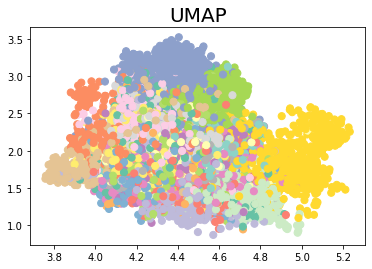

In [8]:
colors = []
colors += cm.get_cmap("Set3").colors
colors += cm.get_cmap("Set2").colors
my_cmap = ListedColormap(colors)

plt.scatter(embeds[:, 19], embeds[:, 8], c = y_train.astype(int), cmap = my_cmap, s = 50)
plt.title('UMAP', fontsize = 20)
plt.show()

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=2)
y_pred_train = kmeans.fit_predict(embeds)





In [10]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 
def evaluate(y, y_pred): 
  print("Accurary Score: %0.3f" % purity_score(y, y_pred))
  print("Adjusted Mutual Information Score: %0.3f" % metrics.adjusted_mutual_info_score(y, y_pred))
  print("Adjusted Rand Index Score: %0.3f" % metrics.adjusted_rand_score(y, y_pred))
  print("Normalized Mutual Information Score: %0.3f" % metrics.normalized_mutual_info_score(y, y_pred))

  print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, y_pred))
  print("Completeness: %0.3f" % metrics.completeness_score(y, y_pred))
  print("V-measure: %0.3f" % metrics.v_measure_score(y, y_pred))


evaluate(y_train, y_pred_train)

Accurary Score: 0.682
Adjusted Mutual Information Score: 0.597
Adjusted Rand Index Score: 0.482
Normalized Mutual Information Score: 0.598
Homogeneity: 0.592
Completeness: 0.604
V-measure: 0.598


In [11]:
#from umap import UMAP
#model = UMAP(n_neighbors = 15, min_dist = 0.1, n_components = 2, verbose = True)
#umap = model.fit_transform(X_train)
#plt.scatter(umap[:, 0], umap[:, 1], c = y_train.astype(int), cmap = my_cmap, s = 50)
#plt.title('UMAP', fontsize = 20)
#plt.show()